In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
# 1. Load Data
X_train = pd.read_csv('cleveland_X_train_processed.csv')
X_test = pd.read_csv('cleveland_X_test_processed.csv')
y_train = pd.read_csv('cleveland_y_train_processed.csv').values.ravel()
y_test = pd.read_csv('cleveland_y_test_processed.csv').values.ravel()

In [4]:
# 2. Define Optuna Objective Function
def objective(trial):
    # Suggest parameters
    # max_depth: depth of the tree (control overfitting)
    max_depth = trial.suggest_int('max_depth', 1, 32)

    # random_state: seed used by the random number generator
    random_state = trial.suggest_int('random_state', 0, 100)

    # Initialize Decision Tree with suggested parameters
    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=random_state
    )

    # 10-Fold Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # n_jobs=-1 uses all CPU cores
    scores = cross_val_score(dt, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

    return scores.mean()

In [5]:
# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-12-04 07:57:48,687] A new study created in memory with name: no-name-2ac52e26-ad3d-48df-8e7e-bea6a9cfd2e1
[I 2025-12-04 07:57:56,831] Trial 0 finished with value: 0.7599567099567099 and parameters: {'max_depth': 6, 'random_state': 78}. Best is trial 0 with value: 0.7599567099567099.
[I 2025-12-04 07:57:57,193] Trial 1 finished with value: 0.7551948051948052 and parameters: {'max_depth': 8, 'random_state': 97}. Best is trial 0 with value: 0.7599567099567099.
[I 2025-12-04 07:57:57,614] Trial 2 finished with value: 0.740909090909091 and parameters: {'max_depth': 16, 'random_state': 4}. Best is trial 0 with value: 0.7599567099567099.
[I 2025-12-04 07:57:57,835] Trial 3 finished with value: 0.7694805194805194 and parameters: {'max_depth': 18, 'random_state': 88}. Best is trial 3 with value: 0.7694805194805194.
[I 2025-12-04 07:57:58,100] Trial 4 finished with value: 0.7792207792207793 and parameters: {'max_depth': 18, 'random_state': 78}. Best is trial 4 with value: 0.7792207792207

In [6]:
best_params = study.best_params
print(f"Best Parameters found: {best_params}")

Best Parameters found: {'max_depth': 18, 'random_state': 78}


In [7]:
# 3. Retrain Model with Best Parameters
best_dt = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    random_state=best_params['random_state']
)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=18, random_state=78)

In [8]:
# 4. Evaluate on Training Data
y_train_pred = best_dt.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# 5. Evaluate on Test Data
y_test_pred = best_dt.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [9]:
# 6. Print Results
print("Training Set Metrics:")
print(f"  Accuracy:  {train_acc * 100:.2f}%")
print(f"  Precision: {train_prec * 100:.2f}%")
print(f"  Recall:    {train_rec * 100:.2f}%")
print(f"  F1 Score:  {train_f1 * 100:.2f}%")

print("Test Set Metrics:")
print(f"  Accuracy:  {test_acc * 100:.2f}%")
print(f"  Precision: {test_prec * 100:.2f}%")
print(f"  Recall:    {test_rec * 100:.2f}%")
print(f"  F1 Score:  {test_f1 * 100:.2f}%")

Training Set Metrics:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1 Score:  100.00%
Test Set Metrics:
  Accuracy:  76.92%
  Precision: 72.92%
  Recall:    81.40%
  F1 Score:  76.92%


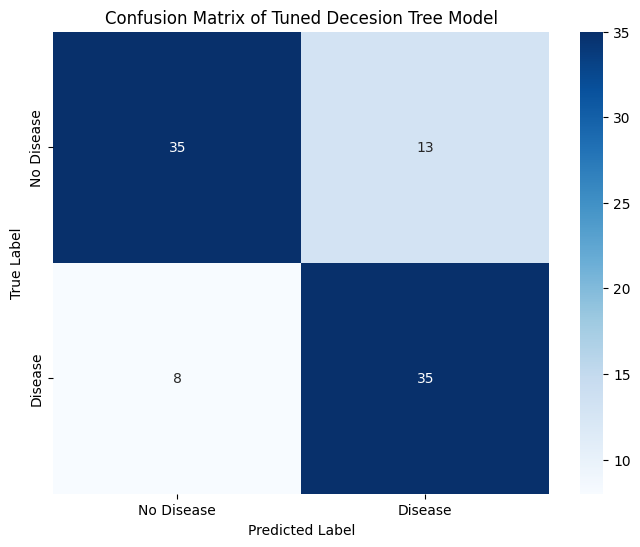

In [10]:
# 7. Visualization of Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Tuned Decesion Tree Model')
plt.show()

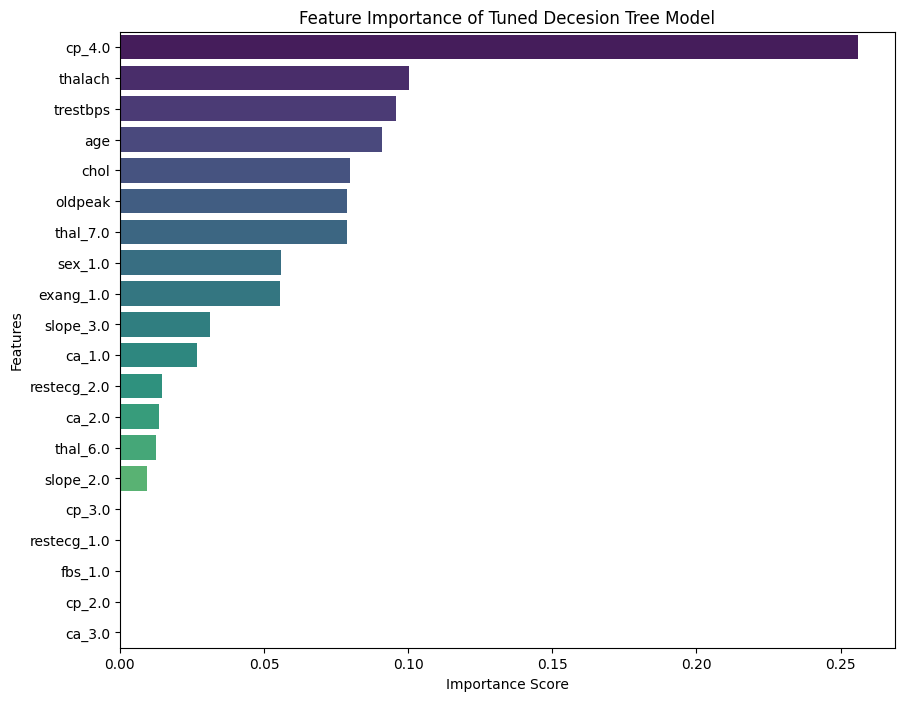

In [11]:
# 8. Visualization of Feature Importance
# Get importance from the trained model
importances = best_dt.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the Top Features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df, palette='viridis', legend=False)
plt.title('Feature Importance of Tuned Decesion Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()